In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50 # type: ignore
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import models, layers # type: ignore
from IPython.display import HTML

In [19]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
CHANNELS=3
EPOCHS=10
n_classes = 4

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "cacao_image",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 822 files belonging to 4 classes.


In [21]:
class_names = dataset.class_names
class_names

['cacao_early_blight', 'cacao_healthy', 'cacao_late_blight', 'cacao_leaf_spot']

In [22]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 0 3 1 0 0 0 3 0 3 0 1 3 2 0 0 0 0 3 1 3 0 0 2 0 0 0 0 1 1 1]


In [23]:
len(dataset)

26

In [24]:
train_size = 0.8
len(dataset)*train_size

20.8

In [25]:
train_ds = dataset.take(20)
len(train_ds)

20

In [26]:
test_ds = dataset.skip(20)
len(test_ds)

6

In [27]:
val_size=0.1
len(dataset)*val_size

2.6

In [28]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [29]:
test_ds = test_ds.skip(2)
len(test_ds)

4

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)

20

In [33]:
len(val_ds)

2

In [34]:
len(test_ds)

4

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.Rescaling(1./256)
])

In [37]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
# Preprocess data for VGG16
data_train_vgg = train_ds.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))
data_val_vgg = val_ds.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))
data_test_vgg = test_ds.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))

In [40]:
# Preprocess data Resnet
data_train_resnet = train_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))
data_val_resnet = val_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))
data_test_resnet = test_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))

In [41]:
model_cnn = models.Sequential([
    layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [42]:
model_cnn.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [43]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
base_model_vgg.trainable = False

global_average_layer_vgg = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_vgg = tf.keras.layers.Dense(n_classes, activation='softmax')

model_vgg = tf.keras.Sequential([
    base_model_vgg,
    global_average_layer_vgg,
    prediction_layer_vgg
])

In [44]:
model_vgg.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [45]:
# Define and compile ResNet50 model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
base_model_resnet.trainable = False

global_average_layer_resnet = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_resnet = tf.keras.layers.Dense(n_classes, activation='softmax')

model_resnet = tf.keras.Sequential([
    base_model_resnet,
    global_average_layer_resnet,
    prediction_layer_resnet
])

In [46]:
model_resnet.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [47]:
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,836 (12.61 MB)

 Trainable params: 3,304,836 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history_cnn = model_cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8975 - loss: 0.2523 - val_accuracy: 0.8906 - val_loss: 0.2654
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9078 - loss: 0.2280 - val_accuracy: 0.8906 - val_loss: 0.2643
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9138 - loss: 0.2378 - val_accuracy: 0.9062 - val_loss: 0.2118
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9183 - loss: 0.2069 - val_accuracy: 0.9375 - val_loss: 0.1140
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9345 - loss: 0.1733 - val_accuracy: 0.9062 - val_loss: 0.2632
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9300 - loss: 0.1893 - val_accuracy: 0.8906 - val_loss: 0.2766
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9457 - loss: 0.1660 - val_accuracy: 0.9219 - val_loss: 0.3002
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9277 - loss: 0.2006 - val_accuracy: 0.9219 - val_loss:

In [50]:
history_vgg = model_vgg.fit(
    data_train_vgg,
    batch_size=BATCH_SIZE,
    validation_data=data_val_vgg,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 253s 13s/step - accuracy: 0.4635 - loss: 2.0387 - val_accuracy: 0.5469 - val_loss: 1.4818
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - accuracy: 0.6831 - loss: 0.9553 - val_accuracy: 0.7812 - val_loss: 0.7751
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - accuracy: 0.7844 - loss: 0.6811 - val_accuracy: 0.8438 - val_loss: 0.6139
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - accuracy: 0.8399 - loss: 0.4970 - val_accuracy: 0.8750 - val_loss: 0.4201
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 262s 12s/step - accuracy: 0.8843 - loss: 0.3940 - val_accuracy: 0.9062 - val_loss: 0.3769
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - accuracy: 0.8700 - loss: 0.4322 - val_accuracy: 0.9219 - val_loss: 0.2897
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 247s 12s/step - accuracy: 0.8975 - loss: 0.3328 - val_accuracy: 0.9219 - val_loss: 0.2357
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - accuracy: 0.9072 - loss: 0.2886 - val_accuracy: 0.

In [52]:
history_resnet = model_resnet.fit(
    data_train_resnet,
    batch_size=BATCH_SIZE,
    validation_data=data_val_resnet,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5279 - loss: 1.0548 - val_accuracy: 0.8906 - val_loss: 0.3244
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9148 - loss: 0.3324 - val_accuracy: 0.9688 - val_loss: 0.1864
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9482 - loss: 0.2239 - val_accuracy: 0.9531 - val_loss: 0.1332
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9471 - loss: 0.1883 - val_accuracy: 0.9688 - val_loss: 0.1180
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9745 - loss: 0.1294 - val_accuracy: 0.9688 - val_loss: 0.0922
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9748 - loss: 0.1248 - val_accuracy: 0.9688 - val_loss: 0.1022
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9535 - loss: 0.1421 - val_accuracy: 0.9688 - val_loss: 0.0781
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9711 - loss: 0.1020 - val_accuracy: 0.9688 - val_loss:

In [53]:
scores_cnn = model_cnn.evaluate(test_ds)
scores_cnn

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - accuracy: 0.8490 - loss: 0.5376


[0.44371867179870605, 0.8671875]

In [54]:
scores_vgg = model_vgg.evaluate(test_ds)
model_vgg

4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.8198 - loss: 0.5377


<Sequential name=sequential_3, built=True>

In [55]:
scores_resnet = model_resnet.evaluate(test_ds)
scores_resnet

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9396 - loss: 0.3076


[0.35787320137023926, 0.90625]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 11s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


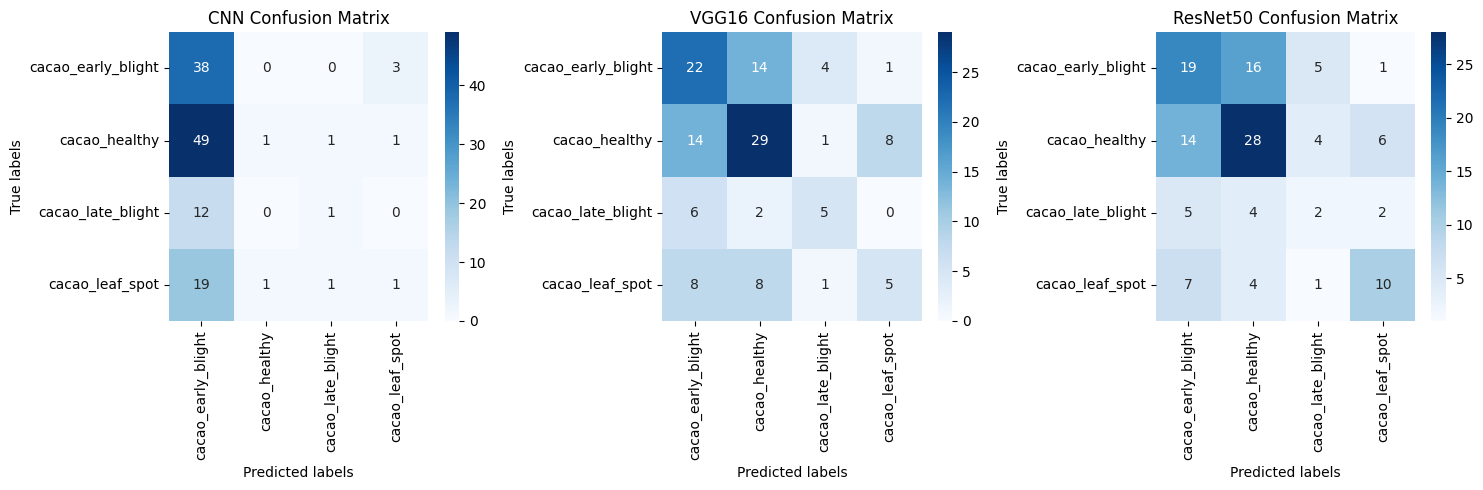

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels for the test dataset
cnn_pred_labels = model_cnn.predict(data_test_resnet)
vgg_pred_labels = model_vgg.predict(data_test_vgg)
resnet_pred_labels = model_resnet.predict(data_test_resnet)

# Get true labels for the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert predicted probabilities to class labels
cnn_pred_labels = np.argmax(cnn_pred_labels, axis=1)
vgg_pred_labels = np.argmax(vgg_pred_labels, axis=1)
resnet_pred_labels = np.argmax(resnet_pred_labels, axis=1)

# Compute confusion matrices
cnn_conf_matrix = confusion_matrix(true_labels, cnn_pred_labels)
vgg_conf_matrix = confusion_matrix(true_labels, vgg_pred_labels)
resnet_conf_matrix = confusion_matrix(true_labels, resnet_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 3, 2)
sns.heatmap(vgg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('VGG16 Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 3, 3)
sns.heatmap(resnet_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.tight_layout()
plt.show()


In [59]:
# Print classification reports
cnn_report = classification_report(true_labels, cnn_pred_labels, target_names=class_names)
vgg_report = classification_report(true_labels, vgg_pred_labels, target_names=class_names)
resnet_report = classification_report(true_labels, resnet_pred_labels, target_names=class_names)

print("CNN Classification Report:")
print(cnn_report)

print("VGG16 Classification Report:")
print(vgg_report)

print("ResNet50 Classification Report:")
print(resnet_report)

CNN Classification Report:
                    precision    recall  f1-score   support

cacao_early_blight       0.32      0.93      0.48        41
     cacao_healthy       0.50      0.02      0.04        52
 cacao_late_blight       0.33      0.08      0.12        13
   cacao_leaf_spot       0.20      0.05      0.07        22

          accuracy                           0.32       128
         macro avg       0.34      0.27      0.18       128
      weighted avg       0.37      0.32      0.19       128

VGG16 Classification Report:
                    precision    recall  f1-score   support

cacao_early_blight       0.44      0.54      0.48        41
     cacao_healthy       0.55      0.56      0.55        52
 cacao_late_blight       0.45      0.38      0.42        13
   cacao_leaf_spot       0.36      0.23      0.28        22

          accuracy                           0.48       128
         macro avg       0.45      0.43      0.43       128
      weighted avg       0.47      0.48

In [64]:
# Save the CNN model
model_cnn.save('cnn_model.keras')

# Save the VGG16 model
model_vgg.save('vgg16_model.keras')

# Save the ResNet50 model
model_resnet.save('resnet50_model.keras')

# Save training histories as JSON files for later analysis
import json

# Save CNN history
cnn_history_dict = history_cnn.history
with open('cnn_history.json', 'w') as f:
    json.dump(cnn_history_dict, f)

# Save VGG16 history
vgg_history_dict = history_vgg.history
with open('vgg_history.json', 'w') as f:
    json.dump(vgg_history_dict, f)

# Save ResNet50 history
resnet_history_dict = history_resnet.history
with open('resnet_history.json', 'w') as f:
    json.dump(resnet_history_dict, f)


In [57]:
print("CNN Model:")
print(f"Accuracy: {accuracy_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1-score: {f1_cnn:.4f}")

print("\nVGG16 Model:")
print(f"Accuracy: {accuracy_vgg:.4f}")
print(f"Precision: {precision_vgg:.4f}")
print(f"Recall: {recall_vgg:.4f}")
print(f"F1-score: {f1_vgg:.4f}")

print("\nResNet50 Model:")
print(f"Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet:.4f}")
print(f"Recall: {recall_resnet:.4f}")
print(f"F1-score: {f1_resnet:.4f}")

CNN Model:
Accuracy: 0.9610
Precision: 0.9641
Recall: 0.9610
F1-score: 0.9605

VGG16 Model:
Accuracy: 0.5766
Precision: 0.6949
Recall: 0.5766
F1-score: 0.5545

ResNet50 Model:
Accuracy: 0.9610
Precision: 0.9671
Recall: 0.9610
F1-score: 0.9614
